# 1 - Learning for Pricing

Consider the case in which all the users belong to class C1. Assume that the curves related to the advertising part of the problem are known, while the curve related to the pricing problem is not. Apply the UCB1 and TS algorithms, reporting the plots of the average (over a sufficiently large number of runs) value and standard deviation of the cumulative regret, cumulative reward, instantaneous regret, and instantaneous reward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from User_Classes import UserClass
from UCB import *
from Learner import *
import numpy as np
import matplotlib.pyplot as plt
from Pricing_Environment import *
from Advertising_Environment import *
from Learner import *

In [2]:
uc1 = UserClass(name = "C1")

In [3]:
class Environment_Pricing_2(): #m
    def __init__(self, n_arms, p):
        self.classes = [
            UserClass(name = 'C1'),
            UserClass(name = 'C2'),
            UserClass(name = 'C3')
        ]
        self.prices = [50, 100, 150, 200, 250]
        self.time = 0
        self.n_arms = n_arms
        self.p = p
        self.ad_env = Advertising_Environment()

    def get_conversion_price_probability(self, class_index, price_index):
        prob = self.classes[class_index].get_conversion_probabilities()[price_index]
        return prob

    def round(self, class_index, price_index, bid=1):
        prices = [50,100,150,200,250]
        clicks = self.ad_env.generate_observations(noise_std_clicks=0, bid=bid, index=class_index)
        conversion_prob = np.random.binomial(1, self.get_conversion_price_probability(0, price_index))
        margin = prices[price_index] - (prices[price_index]/100)*30
        costs = self.ad_env.get_total_cost(noise_std_cost=0, bid=bid, index=class_index)
        reward = clicks * conversion_prob * margin - costs
        self.time += 1
        return reward

In [4]:
n_arms = 5

p = uc1.get_conversion_probabilities()
env = Environment_Pricing(n_arms=n_arms, p = p)
prices = env.prices
costs = 200*0.7
opt = p[3] #optimal arm is the one with the highest probability of success

T = 365 #time steps for each experiment
margins = [i*0.7 for i in range(50, 251, 50)]
print(margins)
n_experiments = 1000
conversions = [0.9,0.7,0.6,0.5,0.4]

[35.0, 70.0, 105.0, 140.0, 175.0]


In [5]:
class TS_Learner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        #Beta has 2 parameters per arm
        self.beta_parameters = np.ones((n_arms, 2))

    #Sampling a value for each arm from a Beta and then select the arm associated to the
    #Beta that generated the sample with the max value
    def pull_arm(self):
        idx = np.argmax(np.random.beta(self.beta_parameters[:,0], self.beta_parameters[:,1]))
        return idx

    def update(self, pulled_arm, reward):
        #Updates the beta parameters based on the pulled arm and the reward from the environment.
        self.t +=1
        #self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm,0] + reward
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1.0 - reward

In [6]:
n_arms = 5

p = uc1.get_conversion_probabilities()
env = Environment_Pricing_2(n_arms=n_arms, p = p)
prices = env.prices


T = 365 #time steps for each experiment

n_experiments = 1000

ts_rewards_per_experiment = [] #list to store the collected rewards for TS_Learner over each experiment
ucb_reward_per_experiment = [] #list to store the collected rewards for Greedy_Learner over each experiment
pulled_arm_number = [0 for i in range(0,5)]
# Loop over the experiments
for e in range (0, n_experiments):
    env_pr = Environment_Pricing_2(n_arms=n_arms, p = p)
    ts_learner = TS_Learner(n_arms=n_arms)
    ucb_learner = UCB(n_arms=n_arms)
    for t in range(0,T):
        #Thompson sampling
        pulled_arm = ts_learner.pull_arm()
        reward = env_pr.round(class_index=0, price_index=pulled_arm, bid=1)
        #print(reward)
        ts_learner.update(pulled_arm, reward/34627)
        ts_learner.update_observations(pulled_arm, reward)
        pulled_arm_number[pulled_arm] += 1
        # Greedy
        pulled_arm = ucb_learner.pull_arm()
        reward = env_pr.round(class_index=0, price_index = pulled_arm, bid=1)
        ucb_learner.update(pulled_arm, reward)


    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_reward_per_experiment.append(ucb_learner.collected_rewards)


# Compute the mean and standard deviation of the cumulative reward at each round
mean_cum_reward_ts = np.mean(ts_rewards_per_experiment, axis=0)
mean_cum_reward_ucb = np.mean(ucb_reward_per_experiment, axis=0)
#std_cum_reward_ts = np.std(ts_rewards_per_experiment, axis=0)

reward_ts = mean_cum_reward_ts
reward_ucb = mean_cum_reward_ucb

#std_cum_reward_ucb = np.std(ucb_reward_per_experiment, axis=0)

### Istantaneous reward

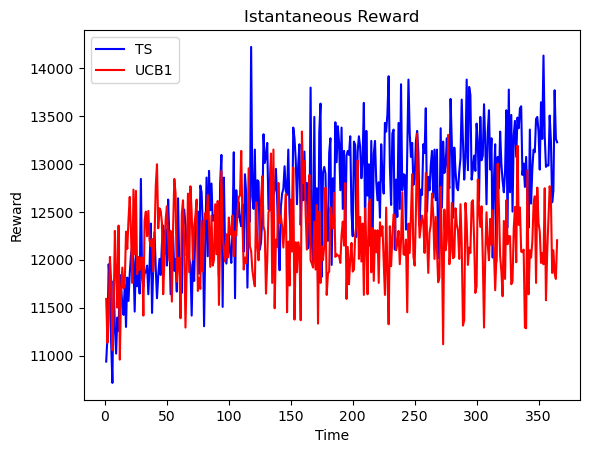

In [10]:
# Plot the results
plt.plot(range(1, T+1), reward_ts, 'b', label='TS')
plt.plot(range(1, T+1), reward_ucb, 'r', label='UCB1')

plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Istantaneous Reward')
plt.legend()
plt.show()

### Cumulative reward

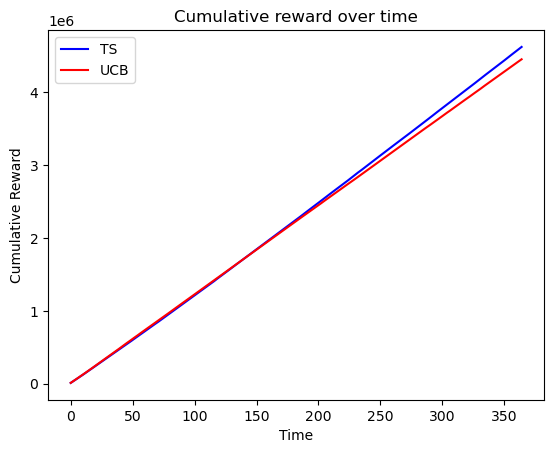

In [11]:
plt.ylabel("Cumulative Reward")
plt.xlabel("Time")
plt.title("Cumulative reward over time")
plt.plot(np.cumsum(np.mean(ts_rewards_per_experiment, axis=0)), 'b', label='TS')
plt.plot(np.cumsum(np.mean(ucb_reward_per_experiment, axis=0)), 'r', label='UCB')
plt.legend()
plt.show()

### Cumulative regret

200 1.0


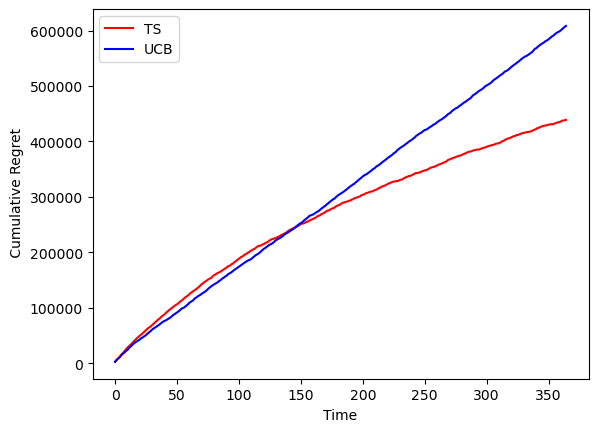

In [13]:
from Clairvoyant import get_optimal_parameters
optimum_price = 200
optimum_bid = 1.0
opt = 200*140*0.5-140
#optimum_price, optimum_bid = get_optimal_parameters(uc1.user_index)
print(optimum_price,optimum_bid)

plt.figure(0)
plt.ylabel(" Cumulative Regret")
plt.xlabel("Time")
plt.plot(np.cumsum(opt - np.array(reward_ts), axis=0), 'r')
plt.plot(np.cumsum(opt - np.array(reward_ucb), axis=0), 'b')
plt.legend(["TS", "UCB"])
plt.show()

### Istantaneous regret

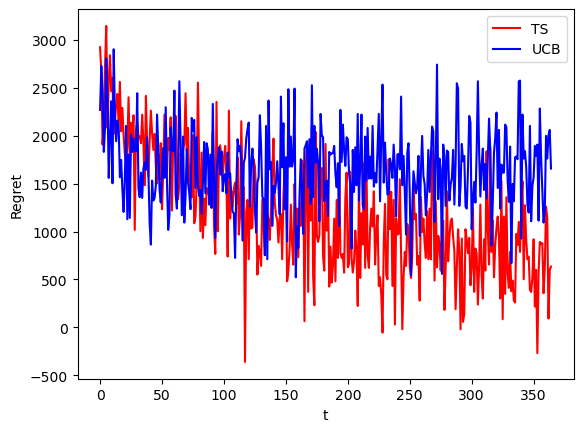

In [17]:
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.mean(opt - np.array(ts_rewards_per_experiment), axis=0), 'r', label='TS')
plt.plot(np.mean(opt - np.array(ucb_reward_per_experiment), axis=0), 'b', label='UCB')
plt.legend()
plt.show()